In [ ]:
!pip install shap
!pip install xgboost
!pip install imbalanced-learn
!pip install scikit-plot
!pip install pycaret

In [31]:
import pandas as pd
import numpy as np
import shap
import itertools
import matplotlib.pyplot as plt

from numpy import sort

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import seaborn as sns # for correlation heatmap

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, recall_score, precision_score, accuracy_score, f1_score, cohen_kappa_score
from sklearn.metrics import classification_report
from sklearn import metrics

from xgboost import XGBClassifier

%matplotlib inline
plt.rcParams["figure.figsize"] = (30,10)

# Data Cleaning

In [4]:
df = pd.read_csv('customer_segmentation.csv')
df['Generation'] = df['Generation'].str.split(' \(').str[0]
df = df[['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
         'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
         'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
         'Response', 'Cluster', 'RFMScore_sum']]
df = df.drop_duplicates()
df.loc[df['Income'] == 666666.0, 'Income'] = np.nan
df['Income'] = df['Income'].fillna(float(round(df['Income'].mean())))
df = df.reset_index(drop=True)

# Data Oversampling

There are features that are categorical. Now we only need to convert these categorical features into numerical, so our model understands the input. We will apply a technique called "One hot encoding". One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

In [33]:
df = pd.get_dummies(df)

One of the problems on this dataset is that the data is imbalanced. We are going to use oversampling techniques to try to balance the minority class, thus having more examples of yes.

In [34]:
X = df.drop(columns=['Response'])
y = df['Response']
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.3, random_state=12)

sample = 'over_under'

if sample == 'smote':
  over = SMOTE(sampling_strategy=0.5, k_neighbors=6)
  X, y = over.fit_resample(X, y)

elif sample == 'over_under':
  over = SMOTE(sampling_strategy=0.5, k_neighbors=4)
  under = RandomUnderSampler(sampling_strategy=0.5)
  steps = [('over', over), ('under', under)]
  pipeline = Pipeline(steps=steps)
  X, y = pipeline.fit_resample(X, y)

elif sample == 'borderline':
  over = BorderlineSMOTE(sampling_strategy=0.5, k_neighbors=10)
  X, y = over.fit_resample(X, y)

elif sample == 'svmsmote':
  over = SVMSMOTE(sampling_strategy=0.3, k_neighbors=6)
  X, y = over.fit_resample(X, y)

elif sample == 'adasyn':
  over = ADASYN(sampling_strategy=0.3, n_neighbors=3)
  X, y = over.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
# t = StandardScaler()
# t.fit(X_train)
# X_train = t.transform(X_train)
# X_test = t.transform(X_test)
# X_test_ = t.transform(X_test_)

1 - Create train data and test data;\
2 - Resample on the original data with oversampling techniques;\
3 - Use resample data to train, removing test data from 1;\
4 - So let's increase our train data with synthetic examples from the minority class;\
5 - The model will be able to learn the pattern of the minority class.

In [35]:
df_1 = X_train_.copy()
df_1['Response'] = y_train_

df_2 = X_train.copy()
df_2['Response'] = y_train

df_3 = X_test.copy()
df_3['Response'] = y_test

df_4 = X_test_.copy()
df_4['Response'] = y_test_

df_new = pd.concat([df_1, df_2, df_3])
df_new = df_new.drop_duplicates()

X_train = df_new.merge(df_4, how = 'outer', indicator=True).loc[lambda x : x['_merge']=='left_only'].drop(columns=['_merge', 'Response'])
y_train = df_new.merge(df_4, how = 'outer', indicator=True).loc[lambda x : x['_merge']=='left_only']['Response']

X_test = df_4.drop(columns=['Response'])
y_test = df_4['Response']

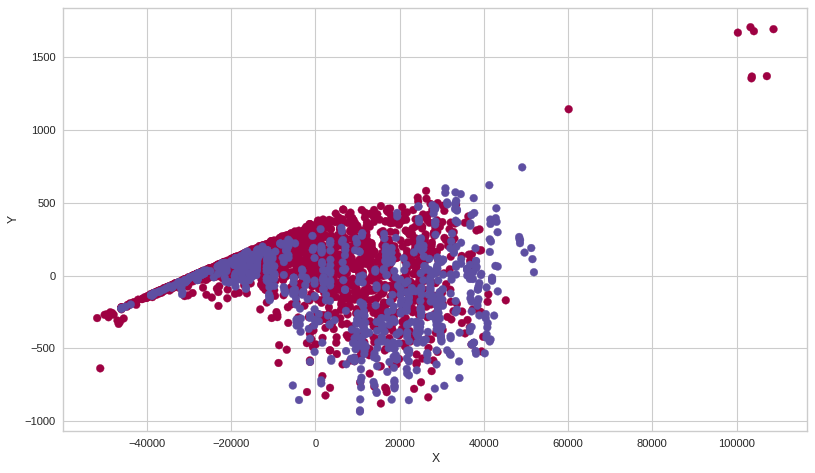

In [36]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2).fit_transform(X)
fig = plt.figure(figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection=None)
ax.scatter(pca.T[0],pca.T[1],c=y,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')

# Modeling v1 - SHAP Values Feature Importance

In [ ]:
from sklearn.ensemble import RandomForestClassifier

my_model = RandomForestClassifier(random_state=0).fit(X_train, y_train)

y_pred = my_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(sample, "Accuracy: %.2f%%" % (accuracy * 100.0))

over_under Accuracy: 87.54%


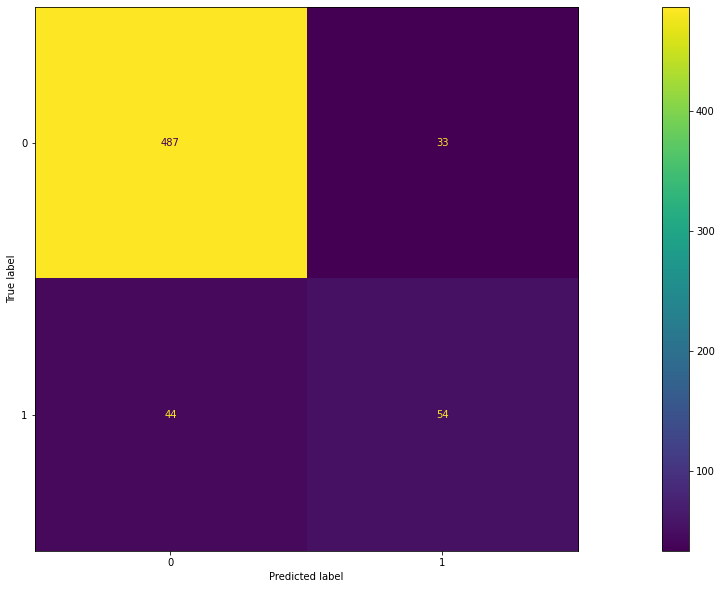

In [ ]:
ConfusionMatrixDisplay.from_estimator(my_model, X_test, y_test)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       520
           1       0.62      0.55      0.58        98

    accuracy                           0.88       618
   macro avg       0.77      0.74      0.76       618
weighted avg       0.87      0.88      0.87       618



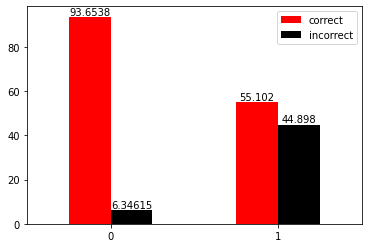

In [57]:
correct = [487/520*100, 54/98*100]
incorrect = [33/520*100, 44/98*100]
index = ['0', '1']
df = pd.DataFrame({'correct': correct,
                   'incorrect': incorrect}, index=index)
ax = df.plot.bar(rot=0, color={"correct": "red", "incorrect": "black"})

for container in ax.containers:
    ax.bar_label(container)

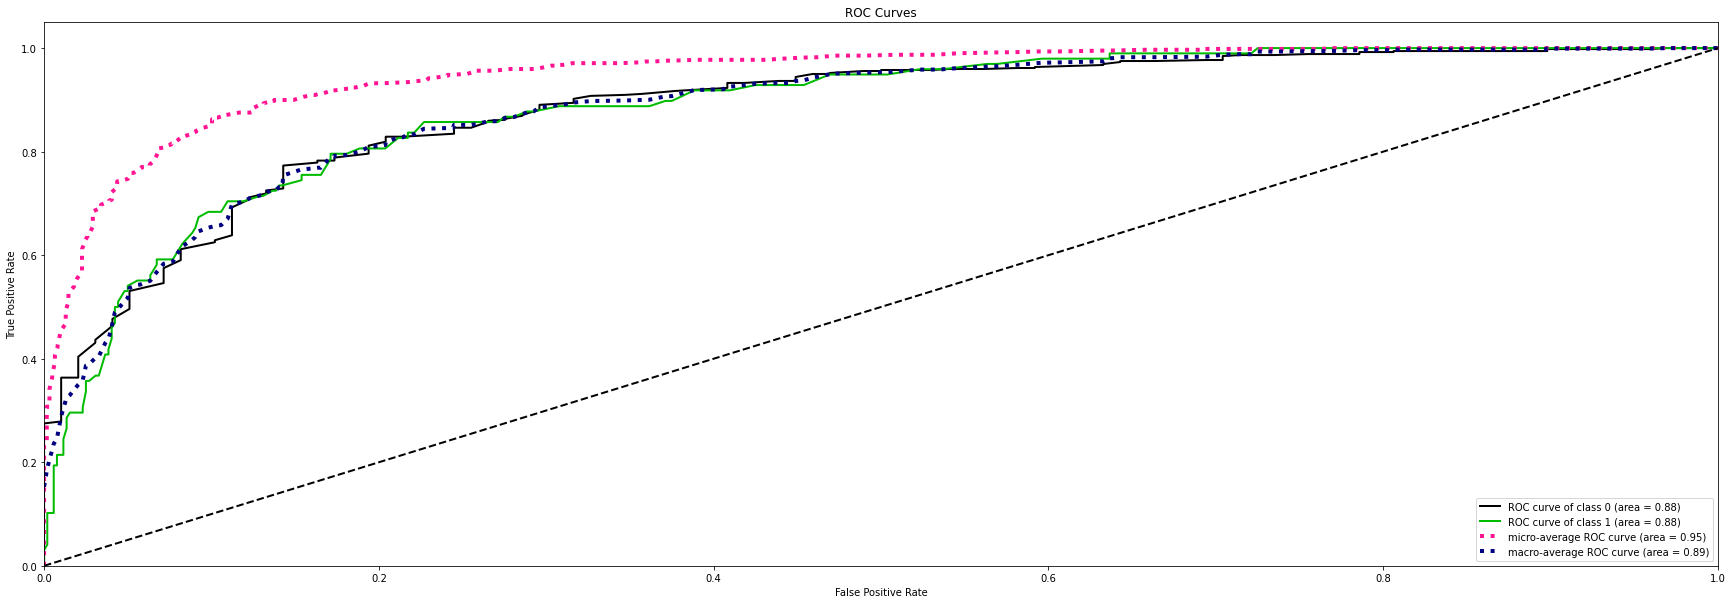

In [ ]:
import scikitplot as skplt

y_probas = my_model.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()

In [ ]:
X_test_1 = X_test.copy()
X_test_1['Response'] = y_test
X_test_1['Response_pred'] = y_pred

In [ ]:
X_test_1 = X_test_1[X_test_1['Response'] != X_test_1['Response_pred']]
X_test_1 = X_test_1[X_test_1['Response'] == 1]
X_test_1 = X_test_1.drop(columns=['Response', 'Response_pred'])

In [ ]:
row_to_show = 0
data_for_prediction = X_test_1.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

my_model.predict_proba(data_for_prediction_array)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


array([[0.71, 0.29]])

In [ ]:
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(data_for_prediction)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)

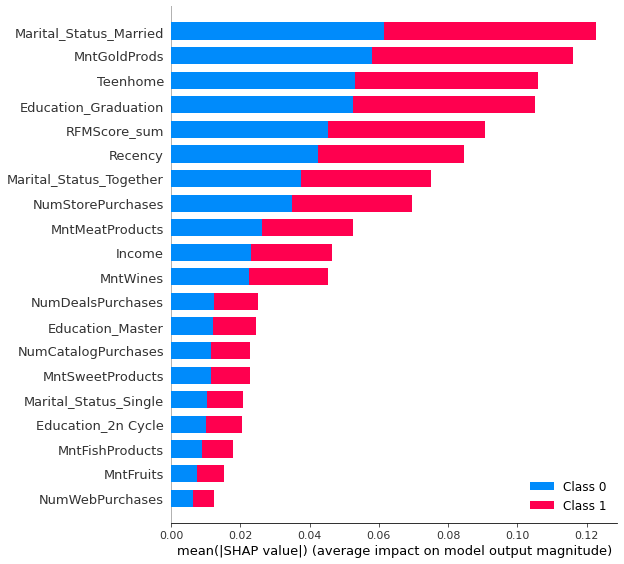

In [ ]:
explainer = shap.TreeExplainer(my_model)
shap_values = explainer.shap_values(X_test_)
shap.summary_plot(shap_values, X_test_, plot_type="bar")

Income, Recency and RFMScore are important variables

# Modeling v2 - pycaret

In [37]:
from pycaret.classification import *

In [41]:
train = X_train.copy()
train['Response'] = y_train

model_setup = setup(data=train,
                    target='Response',
                    remove_multicollinearity=True,
                    multicollinearity_threshold=0.9,
                    session_id=1,
                    silent=True)

,Description,Value
0,session_id,1
1,Target,Response
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(1999, 30)"
5,Missing Values,False
6,Numeric Features,21
7,Categorical Features,8
8,Ordinal Features,False
9,High Cardinality Features,False


Let's start by comparing different model. I will set k-fold cross-validation with k=10 and calculate the accuracy, AUC, recall, precision, F1, and kappa.

In [42]:
compare_models(fold=10, sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8885,0.9447,0.8176,0.8879,0.8504,0.7618,0.7643,0.158
rf,Random Forest Classifier,0.8685,0.9421,0.7715,0.8757,0.8191,0.7166,0.7212,0.603
lda,Linear Discriminant Analysis,0.8935,0.9416,0.7713,0.9464,0.8484,0.7677,0.7786,0.039
gbc,Gradient Boosting Classifier,0.8756,0.9386,0.7844,0.8851,0.8304,0.7328,0.7374,0.413
et,Extra Trees Classifier,0.8713,0.9317,0.7604,0.8925,0.8202,0.7212,0.7276,0.565
ada,Ada Boost Classifier,0.8770,0.9315,0.8065,0.8703,0.8360,0.7379,0.7405,0.198
lr,Logistic Regression,0.7413,0.8045,0.5344,0.7199,0.6082,0.4245,0.4374,0.426
dt,Decision Tree Classifier,0.7984,0.7890,0.7382,0.7453,0.7396,0.5754,0.5777,0.030
knn,K Neighbors Classifier,0.7248,0.7791,0.6591,0.6406,0.6488,0.4228,0.4237,0.132
nb,Naive Bayes,0.6691,0.7578,0.5653,0.5765,0.5689,0.3009,0.3023,0.022


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=1, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

The Light Gradient Boosting Machine showed as the best model. Therefore, I will use this model.

In [43]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9143,0.9461,0.8333,0.9375,0.8824,0.8153,0.8188
1,0.8929,0.9365,0.8148,0.8980,0.8544,0.7699,0.7722
2,0.8571,0.9494,0.7037,0.9048,0.7917,0.6855,0.6981
3,0.8786,0.9456,0.8333,0.8491,0.8411,0.7429,0.7430
4,0.9000,0.9707,0.8519,0.8846,0.8679,0.7875,0.7879
5,0.8643,0.9266,0.7963,0.8431,0.8190,0.7106,0.7114
6,0.8429,0.9316,0.8000,0.8000,0.8000,0.6706,0.6706
7,0.9214,0.9624,0.8545,0.9400,0.8952,0.8326,0.8350
8,0.9000,0.9461,0.8364,0.9020,0.8679,0.7876,0.7891
9,0.9137,0.9318,0.8519,0.9200,0.8846,0.8158,0.8174


In [44]:
model_tuned = tune_model(lightgbm, fold=10, optimize='AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8857,0.9465,0.8148,0.8800,0.8462,0.7555,0.7569
1,0.8786,0.9294,0.7778,0.8936,0.8317,0.7374,0.7418
2,0.8714,0.9348,0.7037,0.9500,0.8085,0.7149,0.7332
3,0.9143,0.9560,0.8704,0.9038,0.8868,0.8179,0.8182
4,0.8786,0.9462,0.8333,0.8491,0.8411,0.7429,0.7430
5,0.8429,0.9233,0.7407,0.8333,0.7843,0.6614,0.6642
6,0.8714,0.9384,0.8727,0.8136,0.8421,0.7339,0.7352
7,0.8786,0.9435,0.8182,0.8654,0.8411,0.7430,0.7437
8,0.9000,0.9350,0.8545,0.8868,0.8704,0.7890,0.7894
9,0.8849,0.9394,0.7963,0.8958,0.8431,0.7527,0.7560


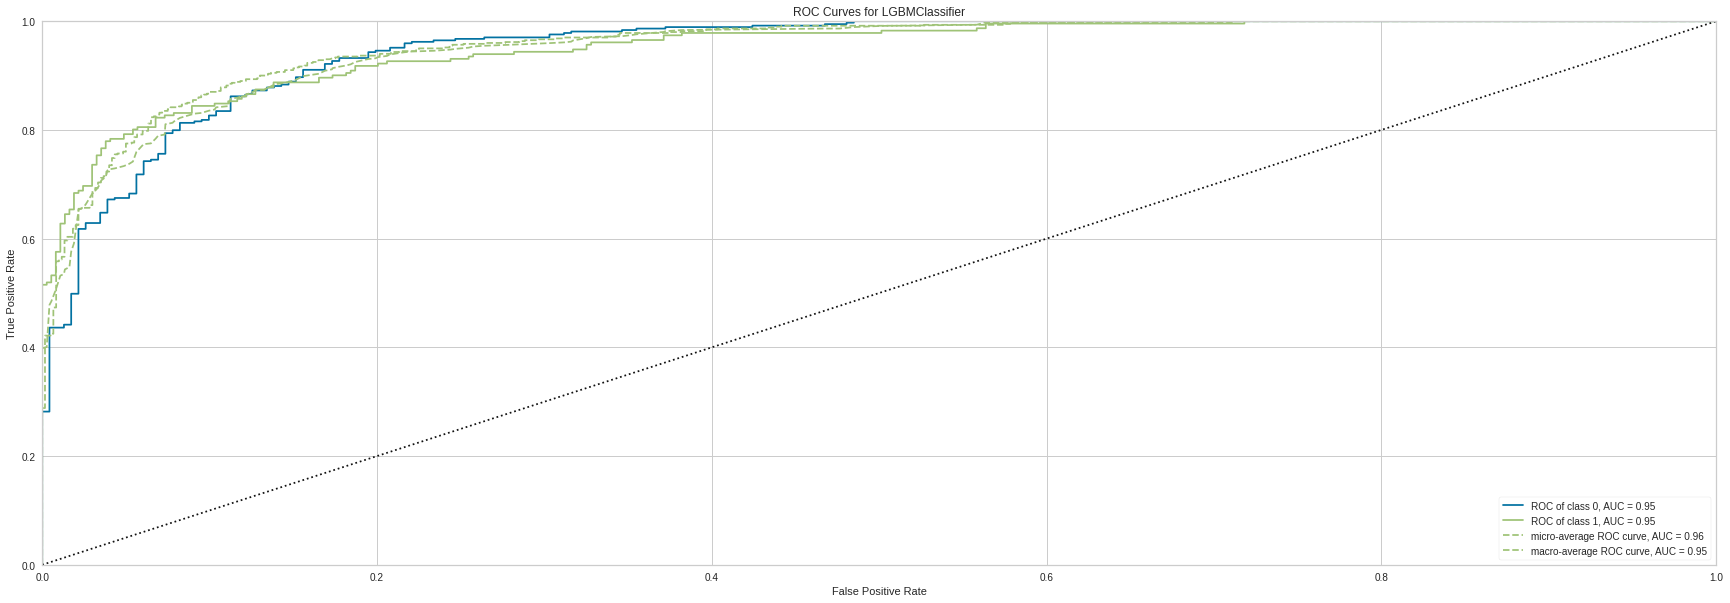

In [48]:
plot_model(model_tuned, plot='auc')

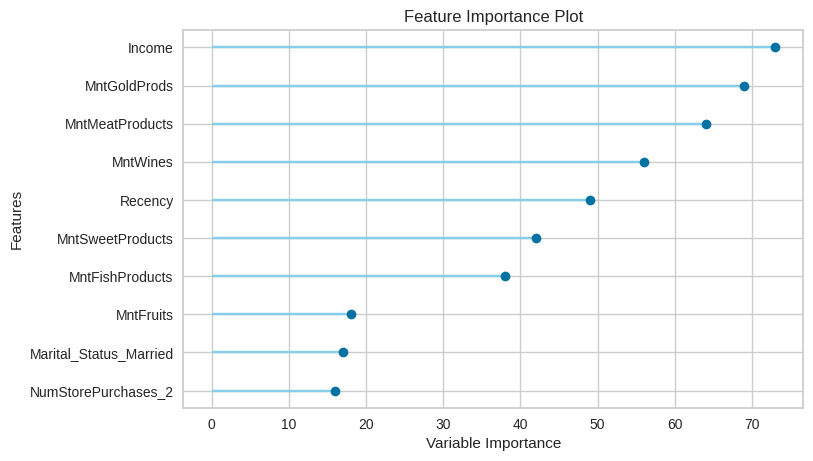

In [46]:
plot_model(model_tuned, plot='feature')

We see that Recency, MntWines, MntGoldProds and MntMeatProducts has the biggest importance in the model prediction. This gives us some guidance on how to improve customer acquisition for the business. Furthermore, Income, as expected, was an important variable for the model.

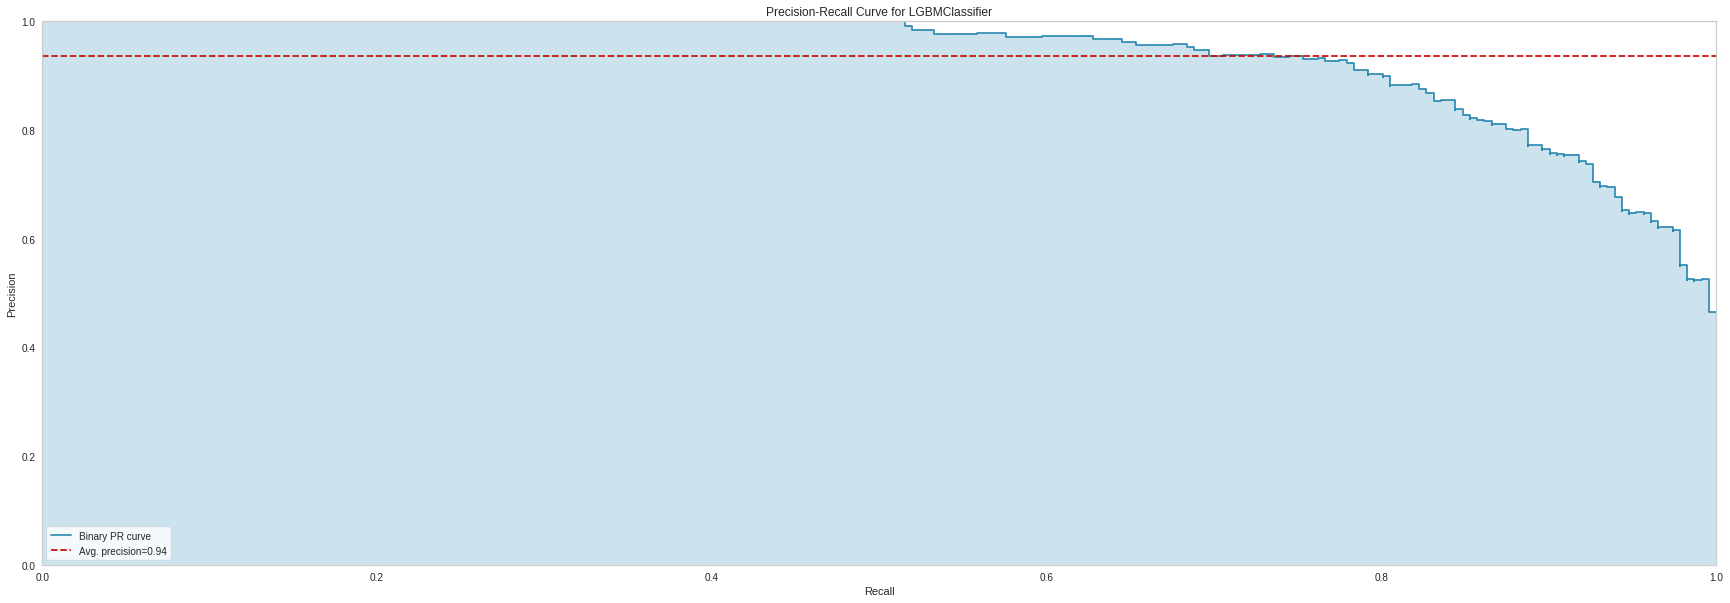

In [50]:
plot_model(model_tuned, plot='pr') 

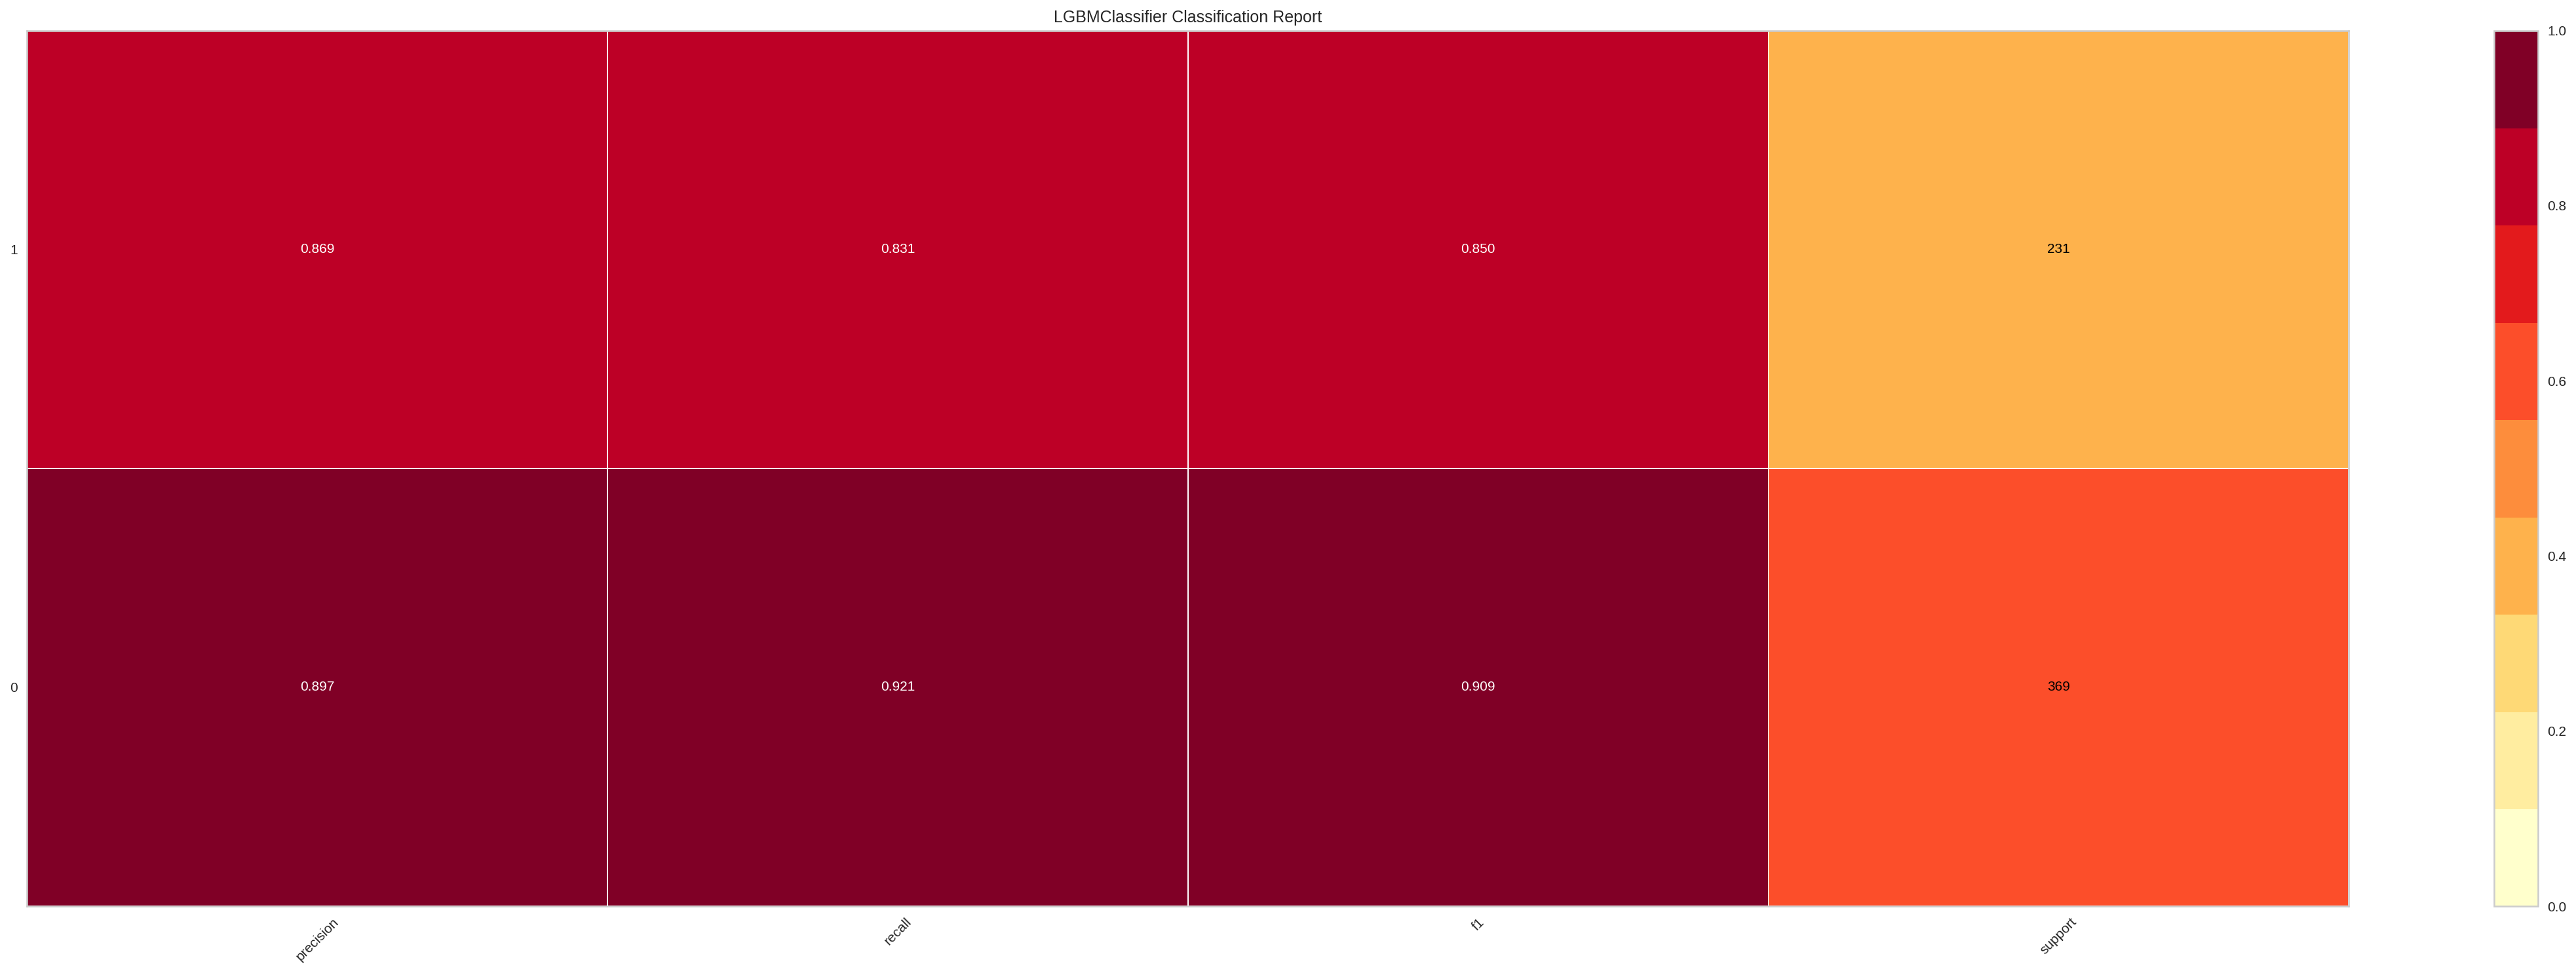

In [54]:
plot_model(model_tuned, plot='class_report') 

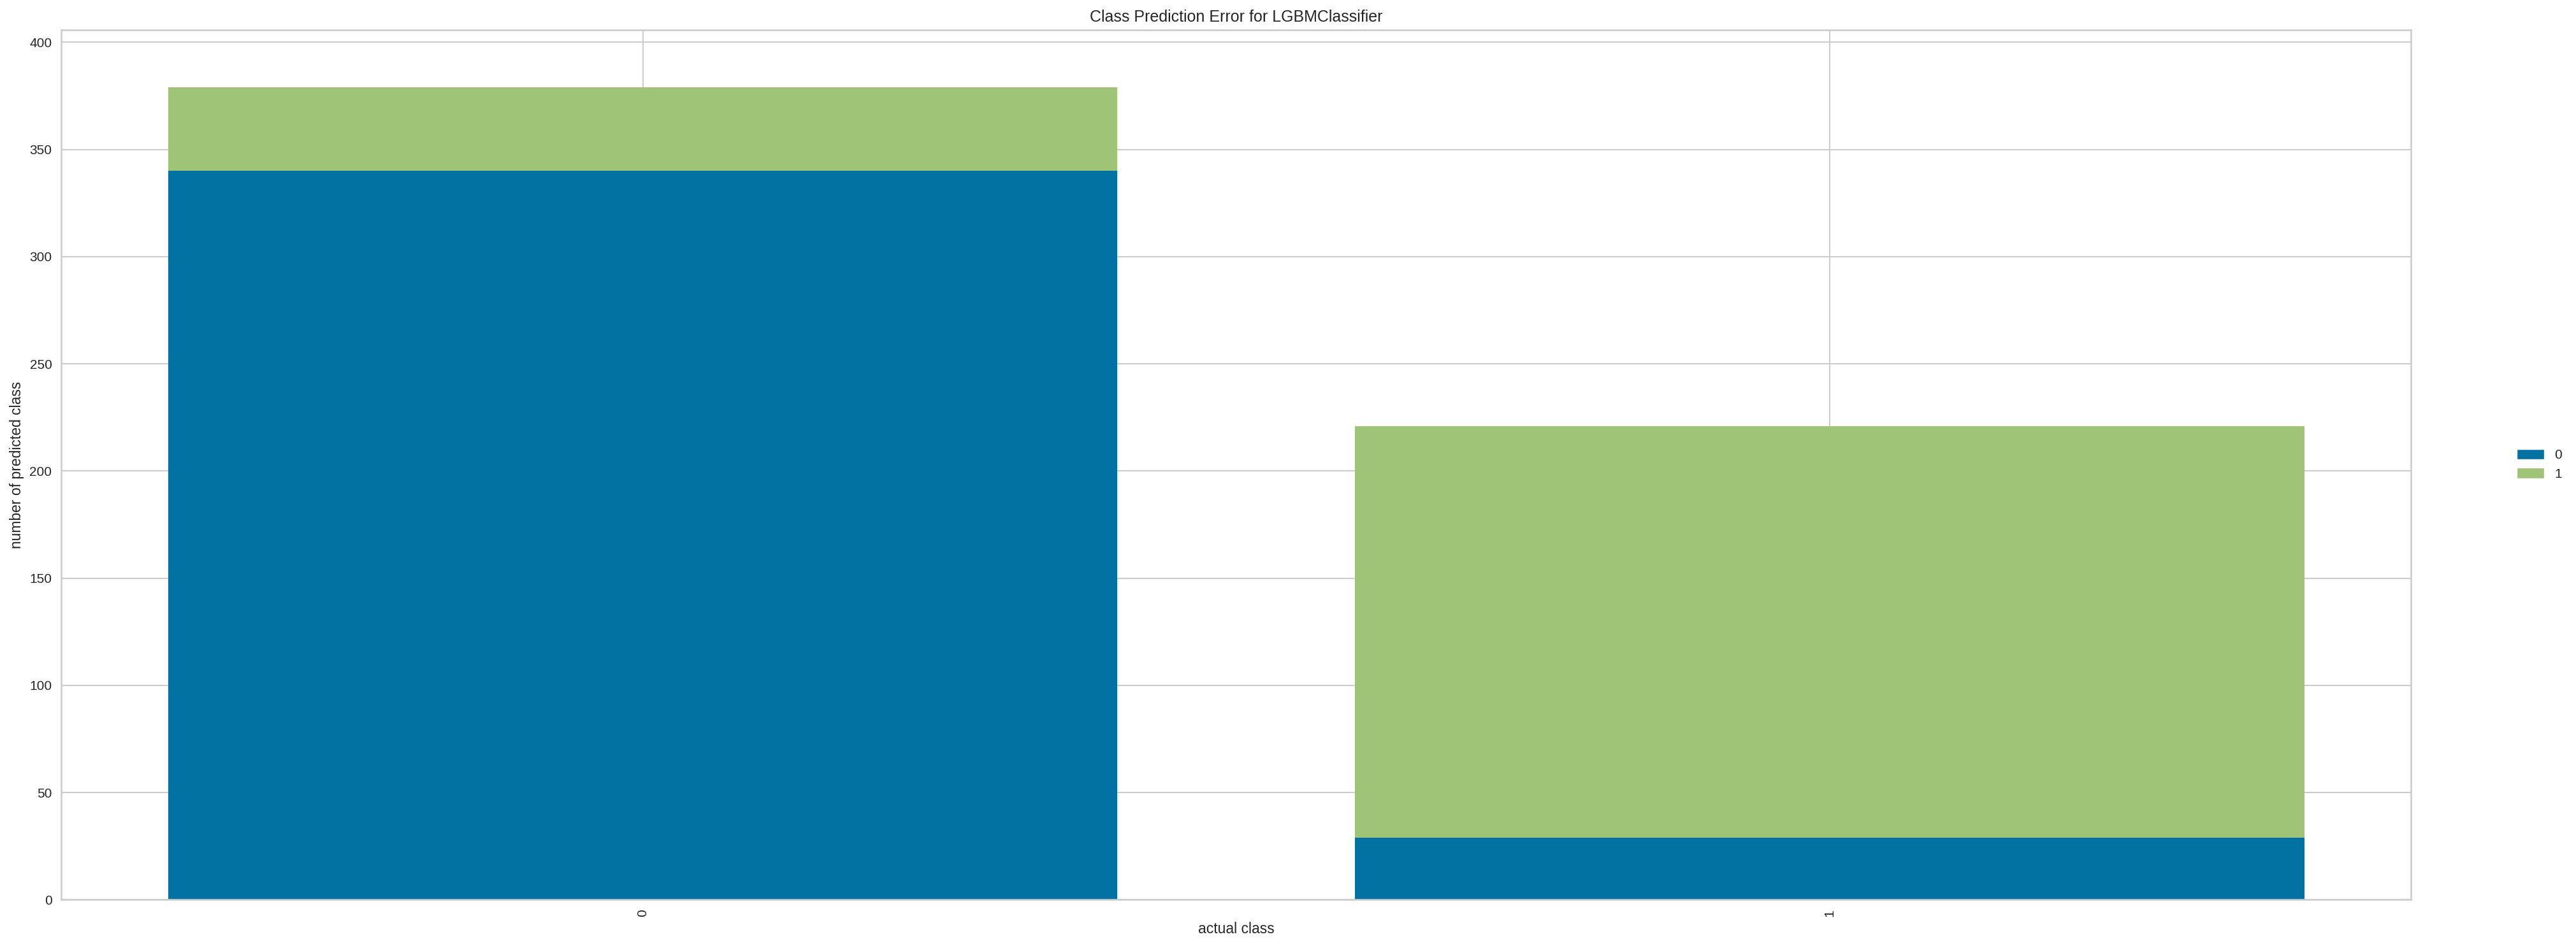

In [55]:
plot_model(model_tuned, plot='error')

## Results


In [56]:
#generate predictions on hold-out set using trained model
y_pred = predict_model(model_tuned, data=X_test)

In [57]:
sc = roc_auc_score(y_test, y_pred['Label'])
recall = recall_score(y_test, y_pred['Label'])
precision = precision_score(y_test, y_pred['Label'])
sca = accuracy_score(y_test, y_pred['Label'])
f1 = f1_score(y_test, y_pred['Label'])
kappa = cohen_kappa_score(y_test, y_pred['Label'])

fold_results = pd.DataFrame({
    'Accuracy': [sca],
    'AUC': [sc],
    'Recall': [recall],
    'Prec.': [precision],
    'F1': [f1],
    'Kappa': [kappa]
}).round(2)
fold_results

,Accuracy,AUC,Recall,Prec.,F1,Kappa
0,0.87,0.73,0.52,0.6,0.56,0.48


In [58]:
print(classification_report(y_test, y_pred['Label']))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       520
           1       0.60      0.52      0.56        98

    accuracy                           0.87       618
   macro avg       0.76      0.73      0.74       618
weighted avg       0.86      0.87      0.87       618



### The model showed that Recency, MntWines, MntGoldProds and MntMeatProducts have a large impact in the model predictions, so in future marketing campaigns this should be considered as an important feature.

### As showed in customer segmentation, Income is a very important feature.

### SHAP Values Feature Importance: RFMScore is a important feature.